# Visualizing MNIST using Variational Autoencoder

## Step 1-3-1

### 1. Data Prep

In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from scipy.stats import norm

import keras
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

K.clear_session()

np.random.seed(514)

### B. Combine Train & Test


In [0]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/digit-recognizer') # Google CoLab


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train_orig = pd.read_csv('./train.csv')
test_orig = pd.read_csv('./test.csv')

train_orig.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# create 'label' column in test dataset; rearrange so that columns are in the same order as in train
test_orig['label'] = 11
testCols = test_orig.columns.tolist()
testCols = testCols[-1:] + testCols[:-1]
test_orig = test_orig[testCols]

In [0]:
combined = pd.concat([train_orig, test_orig], ignore_index = True)

combined.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
combined.tail() 


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
69995,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
69996,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,183,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,252,20,0,0,0,0,0,0,0,0,0,0,0
69997,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
69998,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
69999,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### spliting into training & validation sets

In [0]:
valid = combined.sample(n = 5000, random_state = 555)
train = combined.loc[~combined.index.isin(valid.index)]

# free up some space and delete test and combined
del train_orig, test_orig, combined

valid.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
15545,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24241,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10099,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
57209,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,180,253,180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2947,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
valid.index

Int64Index([15545, 24241, 10099, 57209,  2947, 64528, 15323, 48767, 16657,
            59502,
            ...
            52287,  8887,  8126,  3971,  9084,   855, 24753, 40777, 52209,
            27391],
           dtype='int64', length=5000)

### 2. Reshape & Normalize


In [0]:
# X's
X_train = train.drop(['label'], axis = 1)
X_valid = valid.drop(['label'], axis = 1)

# labels
y_train = train['label']
y_valid = valid['label']

# Normalize and reshape
X_train = X_train.astype('float32') / 255.
X_train = X_train.values.reshape(-1,28,28,1)

X_valid = X_valid.astype('float32') / 255.
X_valid = X_valid.values.reshape(-1,28,28,1)

Look at few random images.

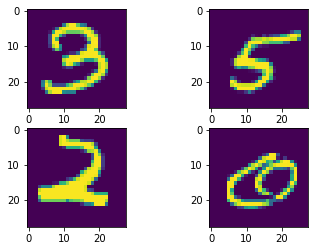

In [0]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[13][:,:,0])

plt.subplot(222)
plt.imshow(X_train[690][:,:,0])

plt.subplot(223)
plt.imshow(X_train[2375][:,:,0])

plt.subplot(224)
plt.imshow(X_train[42013][:,:,0])
plt.show()

### 3. Model Construction

### Encoder Network

In [0]:
img_shape = (28, 28, 1)    # for MNIST
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

In [0]:
# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

B. Sampling function
Next, we create a function to sample from the distribution we just learned the parameters of. epsilon is a tensor of small random normal values. One of the assumptions underlying a VAE like this is that our data arose from a random process and is normally distributed in the latent space.

With Keras, everything has to be in a 'layer' to compile correctly. This goes for our sampling function. The Lambda layer wrapper let's us do this.


In [0]:
# sampling function

def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

C. Decoder network
The decoder is basically the encoder in reverse.

In [0]:
# decoder takes the latent distribution sample as input
decoder_input = layers.Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = layers.Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', 
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

D. Loss
We need one more thing and that's something that will calculate the unique loss function the VAE requires. Recall that the VAE is trained using a loss function with two components:

'Reconstruction loss' - This is the cross-entropy describing the errors between the decoded samples from the latent distribution and the original inputs.
The Kullback-Liebler divergence between the latent distribution and the prior (this acts as a sort of regularization term).
We define a custom layer class that calculates the loss.

In [0]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

Now we can instantiate the model and take a look at its summary.



In [0]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
____________________________________________________________________________________________

In [0]:
vae.fit(x=X_train, y=None,
        shuffle=True,
        epochs=7,
        batch_size=batch_size,
        validation_data=(X_valid, None))

Train on 65000 samples, validate on 5000 samples
Epoch 1/7
65000/65000 [==============================] - 60s 924us/step - loss: 1.3776 - val_loss: 0.1956
Epoch 2/7
65000/65000 [==============================] - 59s 904us/step - loss: 0.1914 - val_loss: 0.1901
Epoch 3/7
65000/65000 [==============================] - 58s 893us/step - loss: 0.1870 - val_loss: 0.1896
Epoch 4/7
65000/65000 [==============================] - 57s 885us/step - loss: 0.1844 - val_loss: 0.1848
Epoch 5/7
65000/65000 [==============================] - 57s 879us/step - loss: 0.1827 - val_loss: 0.1890
Epoch 6/7
65000/65000 [==============================] - 56s 864us/step - loss: 0.1814 - val_loss: 0.1818
Epoch 7/7
65000/65000 [==============================] - 56s 858us/step - loss: 0.1804 - val_loss: 0.1815


5. Results
A. Clustering of digits in the latent space
We can make predictions on the validation set using the encoder network. This has the effect of translating the images from the 784-dimensional input space into the 2-dimensional latent space. When we color-code those translated data points according to their known digit class, we can see how the digits cluster together.

In [0]:
# Isolate original training set records in validation set
valid_noTest = valid[valid['label'] != 11]

# X's and Y's
X_valid_noTest = valid_noTest.drop('label', axis=1)
y_valid_noTest = valid_noTest['label']

# Reshape and normalize
X_valid_noTest = X_valid_noTest.astype('float32') / 255.
X_valid_noTest = X_valid_noTest.values.reshape(-1,28,28,1)

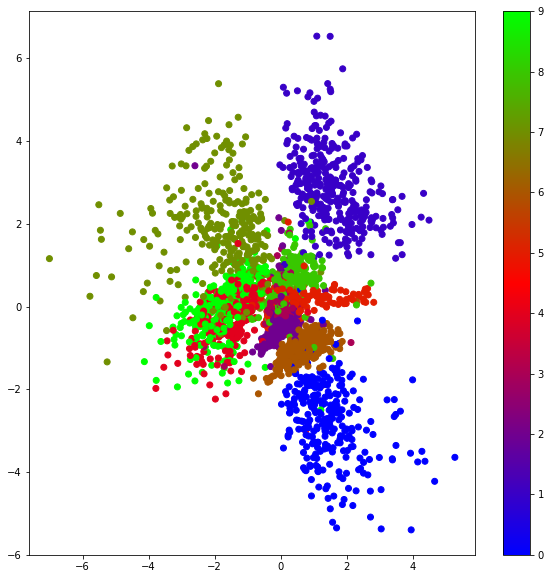

In [0]:
# Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(X_valid_noTest, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=y_valid_noTest, cmap='brg')
plt.colorbar()
plt.show()

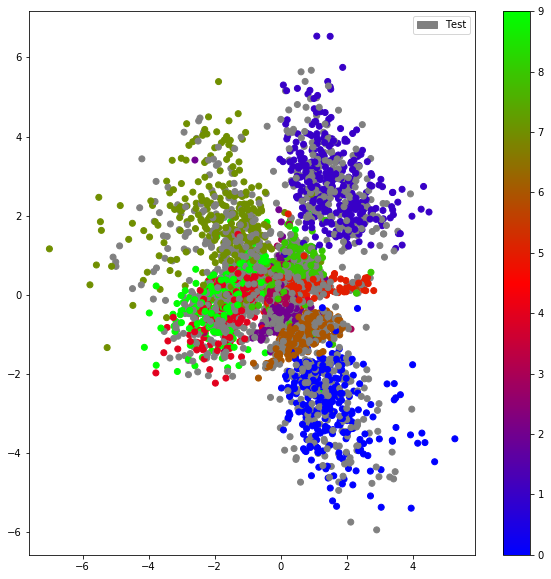

In [0]:
# set colormap so that 11's are gray
custom_cmap = matplotlib.cm.get_cmap('brg')
custom_cmap.set_over('gray')

x_valid_encoded = encoder.predict(X_valid, batch_size=batch_size)
plt.figure(figsize=(10, 10))
gray_marker = mpatches.Circle(4,radius=0.1,color='gray', label='Test')
plt.legend(handles=[gray_marker], loc = 'best')
plt.scatter(x_valid_encoded[:, 0], x_valid_encoded[:, 1], c=y_valid, cmap=custom_cmap)
plt.clim(0, 9)
plt.colorbar()

B. Sample digits
Another fun thing we can do is to use the decoder network to take a peak at what samples from the latent space look like as we change the latent variables. What we end up with is a smoothly varying space where each digit transforms into the others as we dial the latent variables up and down.

In [0]:
# n = 50  # figure with 15x15 digits
# digit_size = 40

# # linearly spaced coordinates on the unit square were transformed
# # through the inverse CDF (ppf) of the Gaussian to produce values
# # of the latent variables z, since the prior of the latent space
# # is Gaussian

# z1 = norm.ppf(np.linspace(0.01, 0.99, n))
# z2 = norm.ppf(np.linspace(0.01, 0.99, n))
# z_grid = np.dstack(np.meshgrid(z1, z2))

# x_pred_grid = decoder.predict(z_grid.reshape(500, latent_dim)).reshape(n, n, digit_size, digit_size)


# # .reshape(n, n, digit_size, digit_size)
# # x_pred_grid = decoder.predict(z_grid)

# plt.figure(figsize=(10, 10))
# plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gnuplot2')
# plt.show()


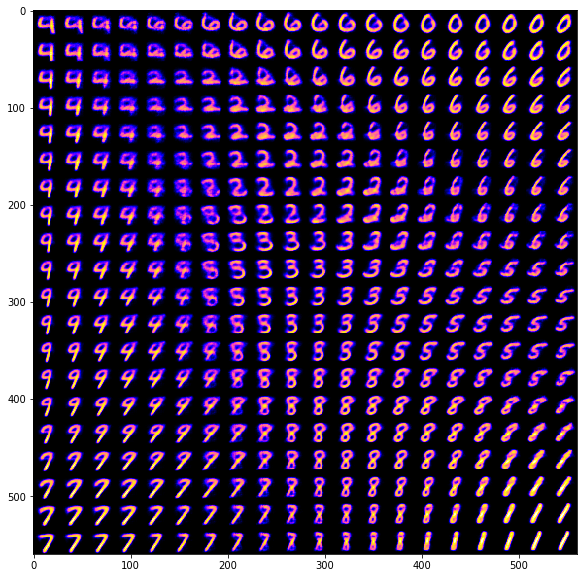

In [0]:
# Display a 2D manifold of the digits
n = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))


# if latent dimension equals 1, then only xi and remove yi

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]*int(latent_dim/2)])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, latent_dim)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.show() 


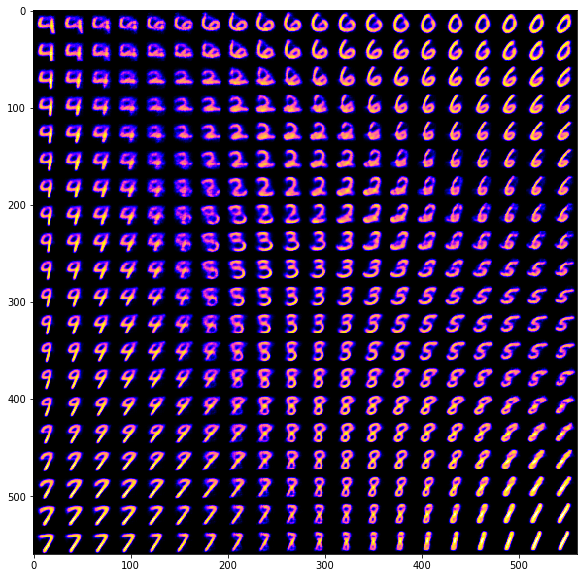

In [0]:
# Display a 2D manifold of the digits
n = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.show() 





### Compare Similarity

In [0]:
pip install ImageHash

In [0]:
from io import BytesIO
from google.colab import files
uploaded = files.upload()



Saving dm1.png to dm1 (1).png
Saving dm2.png to dm2 (1).png


In [0]:
import cv2

dm1 = Image.open('dm1.png')
dm2 = Image.open('dm2.png')



imageA = cv2.imread('dm1.png')
imageB = cv2.imread('dm2.png')


In [0]:
from PIL import Image
import imagehash

hash1 = imagehash.average_hash(Image.open('dm1.png'))
hash2 = imagehash.average_hash(Image.open('dm2.png'))

print(hash1 - hash2)

2
